# Visualize Model Training Results

#### SELECT MODEL/RUN ID

**Best so far**: `20250620_135132_densenet121_softmax_inv` or `20250620_161851_densenet121`

**Notable IDs**: All classes, max_class_size = 10000, each run is ~ 1700 sec without early stopping
- `20250619_125333_densenet121`: does well
- `20250619_151341_densenet121`: new LR scheduler with normalized weights, does well
- `20250620_135132_densenet121_softmax_inv` : new LR scheduler with softmax(1 / class_counts) weights, does really well
- `20250620_143003_densenet121_inv_log`: new LR scheduler with 1 / log(class_counts) weights, does well but slightly worse than softmax
- `20250620_150559_densenet121_inv_sqrt`: new LR scheduler with 1 / sqrt(class_counts) weights, mediocre
- `20250620_154355_densenet121_balanced`: new LR scheduler with train_samples / (num_class * class counts) weights, worse overall, but better for smaller classes
- `20250620_161851_densenet121`: new LR scheduler with no weights, does really well, comparative to softmax_inv but doesn't learn diff b/w Floc 1 vs 2

In [1]:
# Corresponds to the desired model for displaying results

run_name = '20250620_135132_densenet121_softmax_inv'

#### Notebook & Data Set-Up

In [2]:
# Imports
import os
from collections import defaultdict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.metrics import *
from sklearn.preprocessing import label_binarize

In [3]:
# Paths
data_directory = '/data/zooplankton_data'
results_directory = '/home/bushra/Analysis_zooplankton/'

weights_path = os.path.join(results_directory, 'weights', run_name + '.pth')
predictions_path = os.path.join(results_directory, 'predictions', run_name + '.pth')
metadata_path = os.path.join(results_directory, 'environment', run_name + '.pth')

In [4]:
# Load predictions
predictions = torch.load(predictions_path, map_location = torch.device('cpu'))
y_true = predictions[0].numpy()
y_pred = predictions[2].numpy()
y_pred_prob = predictions[1].numpy()

# Load environment/metadata variables
metadata = torch.load(metadata_path, weights_only = False)
model_id, model_name = metadata['model_id'], metadata['model_name']
classes, class_map = metadata['classes'], metadata['class_map']
train_metrics = metadata['train_metrics']
hyperparameters = metadata['hyperparameters']
# image_transforms = metadata['image_transforms']

class_map_rev = {v: k for k, v in class_map.items()}

In [5]:
# Merge Floc_1 and Floc_2 (only for prediction)

def merge_floc_classes(labels):
    merged = labels.copy()
    merged[merged == 8] = 7
    return merged

# y_true = merge_floc_classes(y_true_orig)
# y_pred = merge_floc_classes(y_pred_orig)

# if 'Floc_2' in classes:
#     classes.remove('Floc_2')

#### Model Run Details

In [6]:
print(f'Selected Model: {model_name} (ID: {model_id})')
print('\nClasses:\n ' + '\n '.join(f'{cln}: {clid}' for cln, clid in class_map.items()))
print('\nTraining Parameters:\n ' + '\n '.join(f'{p}: {pv}' for p, pv in hyperparameters.items()))

# print('\nSum of Weights: ', hyperparameters['loss_fn']['weights'].sum())

Selected Model: densenet121 (ID: 20250620_135132)

Classes:
 Bosmina_1: 0
 Bubbles: 1
 Calanoid_1: 2
 Chironomid: 3
 Chydoridae: 4
 Cyclopoid_1: 5
 Daphnia: 6
 Floc_1: 7
 Floc_2: 8
 Herpacticoida: 9
 LargeZ-1: 10
 Nauplii: 11
 Sididae: 12
 TooSmall: 13

Training Parameters:
 loss_fn: {'type': 'CrossEntropyLoss', 'weights': tensor([0.0712, 0.0712, 0.0712, 0.0713, 0.0721, 0.0712, 0.0715, 0.0712, 0.0723,
        0.0713, 0.0712, 0.0714, 0.0715, 0.0712])}
 optimizer: Adam
 lr: 0.0005
 epochs: 60
 scheduler: {'type': 'CosineAnnealingLR', 'T_max': 50}
 early_stopping: {'patience': 10, 'delta': 0.005}


#### Training Metrics

Training stopped early after 57 epochs.


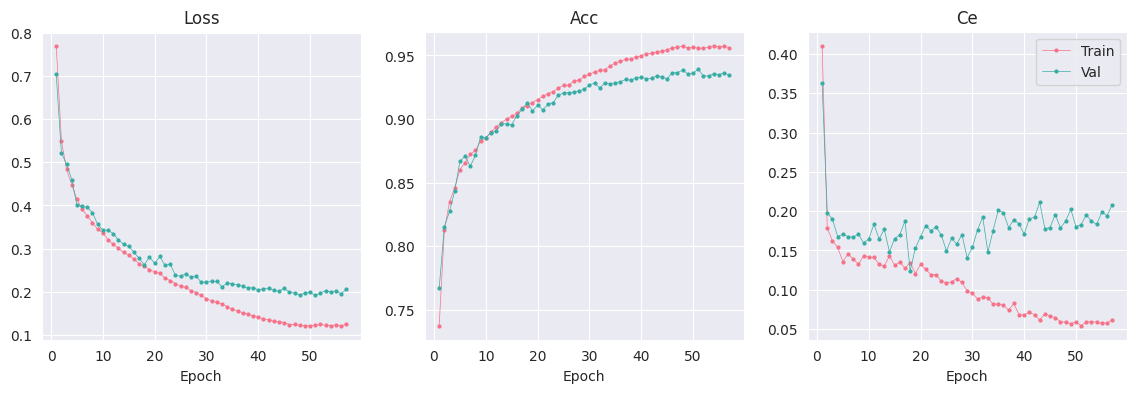

In [7]:
epochs = hyperparameters['epochs']
actual_epochs = len(train_metrics['train_acc'])

# Number of Epochs
if actual_epochs < epochs:
    epochs_enum = list(range(1, actual_epochs+1))
    print(f'Training stopped early after {actual_epochs} epochs.')
else:
    epochs_enum = list(range(1, epochs+1))

sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 3, figsize = (14, 4), sharex = True)
palette = sns.color_palette('husl', n_colors = 2)

metrics = ['loss', 'acc', 'ce']

for i, metric in enumerate(metrics):
    train_values = train_metrics[f'train_{metric}']
    val_values = train_metrics[f'test_{metric}']

    if metric == 'acc':
        val_values = [x / 100 for x in val_values]

    axes[i].plot(epochs_enum, train_values, label = f'Train', marker = 'o', markersize = 2, lw = 0.5, color = palette[0])
    axes[i].plot(epochs_enum, val_values, label = f'Val', marker = 'o', markersize = 2, lw = 0.5, color = palette[1])
    
    axes[i].set_title(metric.capitalize())
    axes[i].set_xlabel('Epoch')
    
plt.legend()
plt.show()


#### Performance Metrics

In [8]:
test_acc = accuracy_score(y_pred, y_true)
test_prec = precision_score(y_pred, y_true, average = 'weighted')
test_recall = recall_score(y_pred, y_true, average = 'weighted')
test_f1 = f1_score(y_pred, y_true, average = 'weighted')

print(f'Accuracy: {test_acc:.4f}\nWeighted Precision: {test_prec:.4f}\nWeighted Recall: {test_recall:.4f}\nWeighted F1: {test_f1:.4f}')

Accuracy: 0.9342
Weighted Precision: 0.9365
Weighted Recall: 0.9342
Weighted F1: 0.9352


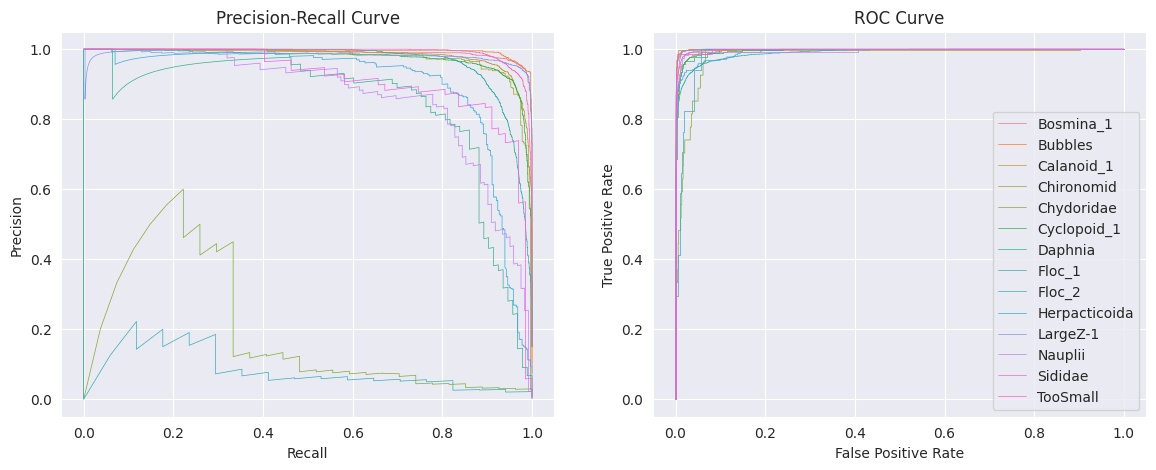

In [9]:
y_true_OHE = label_binarize(y_true, classes = list(class_map.values())) # one hot encoded

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize = (14, 5))
palette = sns.color_palette('husl', n_colors = len(class_map))

for (cln, clid), col in zip(class_map.items(), palette):
    precision, recall, _ = precision_recall_curve(y_true_OHE[:, clid], y_pred_prob[:, clid])
    axs[0].plot(recall, precision, label = f'{cln}', lw = 0.5, color = col)

    fpr, tpr, _ = roc_curve(y_true_OHE[:, clid], y_pred_prob[:, clid])
    axs[1].plot(fpr, tpr, label = f'{cln}', lw = 0.5, color = col)

axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision-Recall Curve')

axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')

plt.legend(loc = 'best')
plt.show()

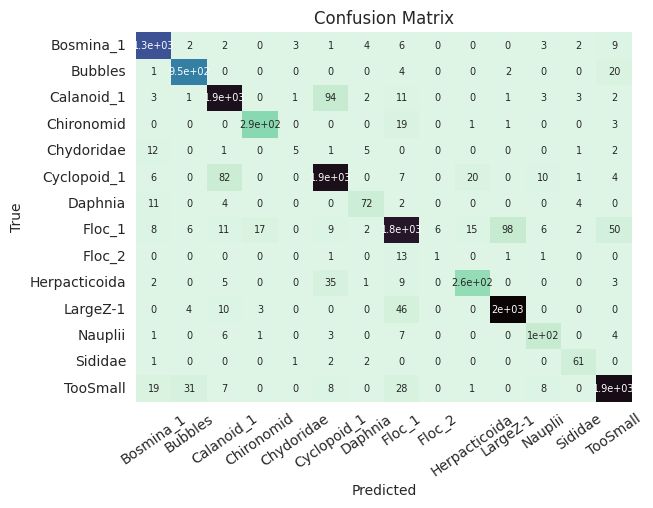

In [10]:
# Get confusion matrix data
cm = confusion_matrix(y_true, y_pred)
annot_kws = {'size': 7}

# Plot
sns.heatmap(cm, annot = True, annot_kws = annot_kws, cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation = 35)

# plt.tight_layout()
plt.show()

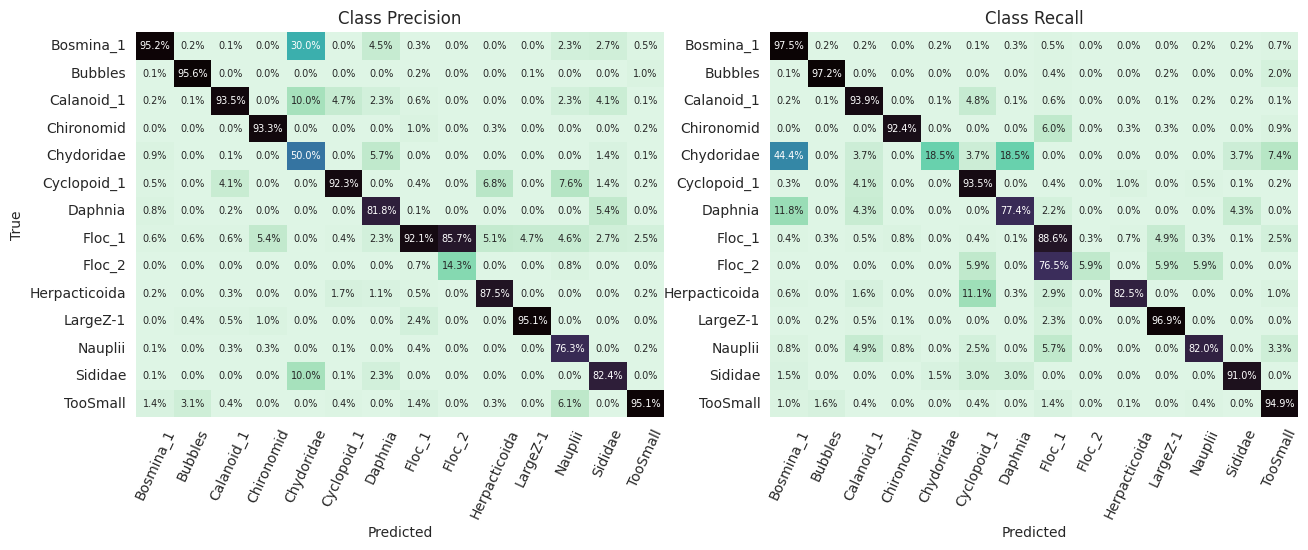

In [11]:
# Get confusion matrix data
cm_col_percent = cm / cm.sum(axis = 0, keepdims = True)
annot_col = np.array([[f"{val:.01%}" for val in row] for row in cm_col_percent])

cm_row_percent = cm / cm.sum(axis = 1, keepdims = True)
annot_row = np.array([[f"{val:.01%}" for val in col] for col in cm_row_percent])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.heatmap(cm_col_percent, annot = annot_col, annot_kws = annot_kws, fmt = '', cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False, ax = axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Class Precision')
axs[0].tick_params(axis = 'x', rotation = 65)

sns.heatmap(cm_row_percent, annot = annot_row, annot_kws = annot_kws, fmt = '', cmap = 'mako_r', xticklabels = classes, yticklabels = classes, cbar = False, ax = axs[1])
axs[1].set_xlabel('Predicted')
# axs[1].set_ylabel('True')
axs[1].set_title('Class Recall')
axs[1].tick_params(axis = 'x', rotation = 65)

plt.show()

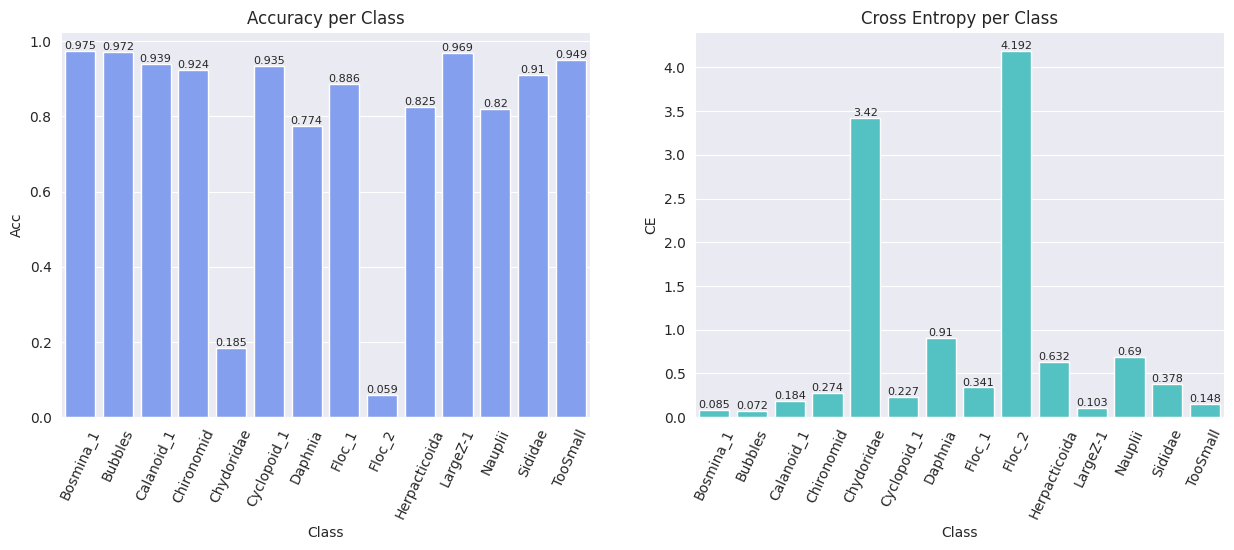

In [12]:
# Get Accuracy and CE data
y_true_tensor = predictions[0]
y_pred_tensor = predictions[2]
y_log_prob_tensor = predictions[1].log()

acc_per_class = {
    cln: (y_pred_tensor[y_true_tensor == clid] == clid).float().mean().item() for cln, clid in class_map.items()
}

losses = F.cross_entropy(y_log_prob_tensor, y_true_tensor, reduction = 'none') # loss per sample
class_loss = defaultdict(list)

# Sort losses by class
for loss, y in zip(losses, y_true_tensor):
    class_loss[int(y)].append(loss.item())

# Average losses per class
mean_loss_per_class = {class_map_rev[cls]: sum(vals) / len(vals) for cls, vals in class_loss.items()}
mean_loss_per_class = dict(sorted(mean_loss_per_class.items()))

# Plot
sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x = list(acc_per_class.keys()), y = np.round(list(acc_per_class.values()), 3), color = '#7297ff', ax = axs[0])
axs[0].set_title('Accuracy per Class')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Acc')
axs[0].tick_params(axis = 'x', rotation = 65)
axs[0].bar_label(axs[0].containers[0], fontsize = 8)

sns.barplot(x = list(mean_loss_per_class.keys()), y = np.round(list(mean_loss_per_class.values()), 3), color = '#42d4d4', ax = axs[1])
axs[1].set_title('Cross Entropy per Class')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('CE')
axs[1].tick_params(axis = 'x', rotation = 65)
axs[1].bar_label(axs[1].containers[0], fontsize = 8)

plt.show()